<a href="https://colab.research.google.com/github/Eezzeldin/candy/blob/ATE/candy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install gplearn

In [2]:
#!pip install causalml

In [3]:
import pandas as pd
import numpy as np

import causalml

In [4]:
#!pip show causalml

In [5]:
data = pd.read_csv ("/content/candy-data.csv")
data

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,45.466282
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,39.011898
82,Welch's Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,44.375519
83,Werther's Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,41.904308


In [6]:
rare_cols  = ["peanutyalmondy" , "nougat" , "bar" , "hard" , "caramel" , 'crispedricewafer']
data ["rare"] = 0
for r in rare_cols : data ["rare"] = data ["rare"] + data [r]
data ["rare"] = np.where (data ["rare"] >= 1 , 1 , 0)

In [7]:
data ["peanutyalmondy"].value_counts()

0    71
1    14
Name: peanutyalmondy, dtype: int64

array([[<Axes: title={'center': 'chocolate'}>,
        <Axes: title={'center': 'fruity'}>,
        <Axes: title={'center': 'caramel'}>,
        <Axes: title={'center': 'peanutyalmondy'}>],
       [<Axes: title={'center': 'nougat'}>,
        <Axes: title={'center': 'crispedricewafer'}>,
        <Axes: title={'center': 'hard'}>,
        <Axes: title={'center': 'bar'}>],
       [<Axes: title={'center': 'pluribus'}>,
        <Axes: title={'center': 'sugarpercent'}>,
        <Axes: title={'center': 'pricepercent'}>,
        <Axes: title={'center': 'winpercent'}>],
       [<Axes: title={'center': 'rare'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

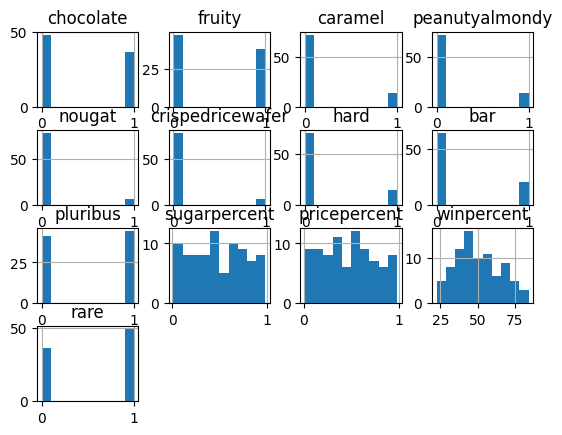

In [8]:
data.hist()

array([[<Axes: title={'center': 'winpercent'}>,
        <Axes: title={'center': 'sugarpercent'}>],
       [<Axes: title={'center': 'pricepercent'}>, <Axes: >]], dtype=object)

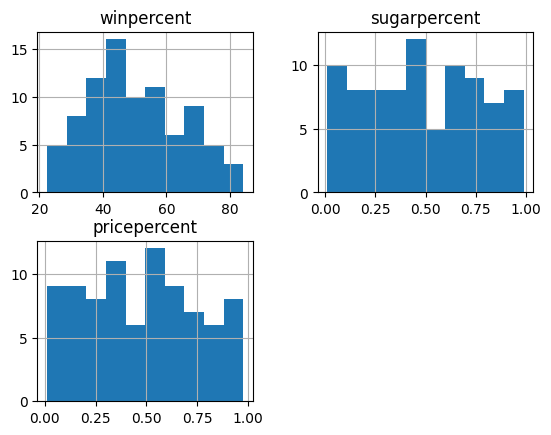

In [9]:
data[["winpercent" , "sugarpercent" , "pricepercent"]].hist()

In [10]:
data ["sugarpercent"] = data ["sugarpercent"] * 100
data ["pricepercent"] = data ["pricepercent"] * 100

In [11]:
y_col            = "winpercent"
non_feature_cols = ["competitorname",
                    "pricepercent" ,
                    "sugarpercent" ,
                    "fruity",
                    y_col
                    ]
for r in rare_cols :      non_feature_cols.append (r)
X                = data.drop (non_feature_cols,axis =1)
X

,chocolate,pluribus,rare
0,1,0,1
1,1,0,1
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
80,0,0,0
81,0,0,1
82,0,1,0
83,0,0,1


In [12]:
X.corr ()

,chocolate,pluribus,rare
chocolate,1.000000,-0.339675,0.416387
pluribus,-0.339675,1.000000,-0.446216
rare,0.416387,-0.446216,1.000000


array([[<Axes: title={'center': 'chocolate'}>,
        <Axes: title={'center': 'pluribus'}>],
       [<Axes: title={'center': 'rare'}>, <Axes: >]], dtype=object)

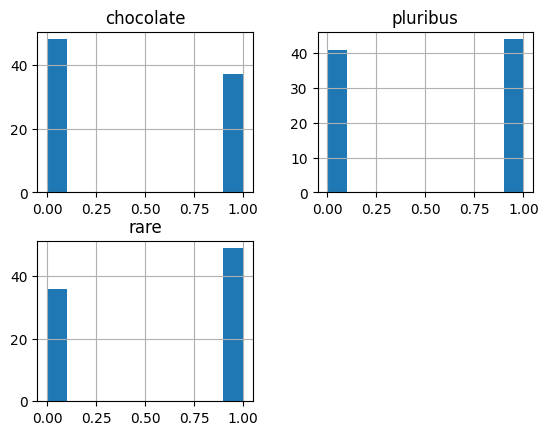

In [13]:
X.hist ()

In [14]:
y = data [y_col]
y

0     66.971725
1     67.602936
2     32.261086
3     46.116505
4     52.341465
        ...    
80    45.466282
81    39.011898
82    44.375519
83    41.904308
84    49.524113
Name: winpercent, Length: 85, dtype: float64

<Axes: >

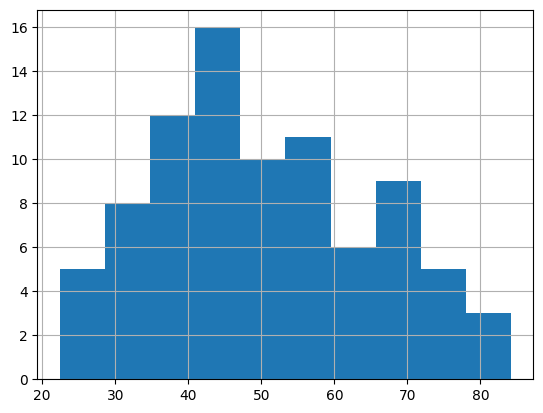

In [15]:
y.hist()

In [16]:
X.join (y).to_csv ("ATE_pp.csv")

In [17]:
from causalml.inference.meta import BaseTRegressor
from sklearn.ensemble import RandomForestRegressor

# Initialize the T-learner with RandomForest as the base regressor
t_learner = BaseTRegressor(learner=RandomForestRegressor())

# Fit the T-learner model
# X represents covariates, treatment is the treatment variable, and y is the outcome
t_learner.fit(X=data[['pluribus', 'rare']], treatment=data['chocolate'], y=data['winpercent'])

# Estimate the Average Treatment Effect (ATE)
ate = t_learner.estimate_ate(X=data[['pluribus', 'rare']], treatment=data['chocolate'], y=data['winpercent'])

# ate returns a tuple with the ATE estimate and confidence intervals, which can be printed or analyzed further
print(f"Estimated ATE: {ate[0]}")


Estimated ATE: [16.36288686]


In [18]:
from causalml.inference.meta import BaseTRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Define a function to estimate ATE and its confidence interval


# Example usage for 'chocolate'
X = data[['pluribus', 'rare']]
treatment = data['chocolate']
y = data['winpercent']

model = BaseTRegressor(learner=RandomForestRegressor())
model.fit(X=X, treatment=treatment, y=y)
ate, ate_lb, ate_ub = model.estimate_ate(X=X, treatment=treatment, y=y)

print(f"ATE: {ate}, Lower Bound: {ate_lb}, Upper Bound: {ate_ub}")


ATE: [16.21073238], Lower Bound: [11.21983483], Upper Bound: [21.20162993]


In [19]:
# Predict the outcomes using the model for the treated and control groups
y_pred_treated = model.model_t.fit (X,y).predict(X[treatment == 1])
y_pred_control = model.model_c.fit (X,y).predict(X[treatment == 0])

# Combine predictions (this step may vary based on your specific needs and setup)
y_pred_combined = np.concatenate([y_pred_treated, y_pred_control])
y_true_combined = np.concatenate([y[treatment == 1], y[treatment == 0]])

# Calculate R^2 and RMSE
r2 = r2_score(y_true_combined, y_pred_combined)
rmse = np.sqrt(mean_squared_error(y_true_combined, y_pred_combined))

print(f"Prediction R^2: {r2}, RMSE: {rmse}")


Prediction R^2: 0.13932761128299764, RMSE: 13.570330234198192


In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from causalml.inference.meta import BaseTRegressor
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Assuming data, X, treatment, and y are already defined as per your dataset
X         = data[['pluribus', 'rare']]
treatment = data['chocolate']
y         = data['winpercent']

# Define the parameter distribution
param_dist = {
    "n_estimators": randint(100, 200),
    "max_depth": randint(3, 20),
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 11)
}


# Setup the Randomized Search with cross-validation for the entire dataset
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_dist, n_iter=100, cv=10, random_state=42, n_jobs = -1 , verbose = 40)

# Perform the search on the entire dataset
random_search.fit(X, y)
best_params = random_search.best_params_


y_pred = random_search.predict (X)

# Calculate R^2 and RMSE
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"Prediction R^2: {r2}, RMSE: {rmse}")



# Apply the best hyperparameters to the RandomForestRegressor
optimized_rf = RandomForestRegressor(**best_params)

# Initialize the BaseTRegressor with the optimized RandomForestRegressor
t_learner = BaseTRegressor(learner=optimized_rf)

# Fit the T-learner to the full dataset
t_learner.fit(X=X, treatment=treatment, y=y)

# Estimate the ATE, its lower and upper bounds
ate, ate_lb, ate_ub = t_learner.estimate_ate(X=X, treatment=treatment, y=y)

print(f"ATE: {ate[0]}, Lower Bound: {ate_lb[0]}, Upper Bound: {ate_ub[0]}")


# Prediction performance evaluation would follow the same logic as before
# Predict the outcomes using the model for the treated and control groups
y_pred_treated = model.model_t.fit (X,y).predict(X[treatment == 1])
y_pred_control = model.model_c.fit (X,y).predict(X[treatment == 0])

# Combine predictions (this step may vary based on your specific needs and setup)
y_pred_combined = np.concatenate([y_pred_treated, y_pred_control])
y_true_combined = np.concatenate([y[treatment == 1], y[treatment == 0]])


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Prediction R^2: 0.11247428885576882, RMSE: 13.780404085613396
ATE: 19.613803535187124, Lower Bound: 14.692287109422132, Upper Bound: 24.535319960952116


In [ ]:
pd.DataFrame (random_search.cv_results_).to_csv ("hyperparams.csv")

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from causalml.inference.meta import BaseTRegressor
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Assuming data, X, treatment, and y are already defined as per your dataset
X         = data[['pluribus', 'rare']]
treatment = data['chocolate']
y         = data['pricepercent']

# Define the parameter distribution
param_dist = {
    "n_estimators": randint(100, 200),
    "max_depth": randint(3, 20),
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 11)
}

# Setup the Randomized Search with cross-validation for the entire dataset
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_dist, n_iter=100, cv=10, random_state=42, n_jobs = -1 , verbose = 40)

# Perform the search on the entire dataset
random_search.fit(X, y)
best_params = random_search.best_params_


y_pred = random_search.predict (X)

# Calculate R^2 and RMSE
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"Prediction R^2: {r2}, RMSE: {rmse}")



# Apply the best hyperparameters to the RandomForestRegressor
optimized_rf = RandomForestRegressor(**best_params)

# Initialize the BaseTRegressor with the optimized RandomForestRegressor
t_learner = BaseTRegressor(learner=optimized_rf)

# Fit the T-learner to the full dataset
t_learner.fit(X=X, treatment=treatment, y=y)

# Estimate the ATE, its lower and upper bounds
ate, ate_lb, ate_ub = t_learner.estimate_ate(X=X, treatment=treatment, y=y)

print(f"ATE: {ate[0]}, Lower Bound: {ate_lb[0]}, Upper Bound: {ate_ub[0]}")


# Prediction performance evaluation would follow the same logic as before
# Predict the outcomes using the model for the treated and control groups
y_pred_treated = model.model_t.fit (X,y).predict(X[treatment == 1])
y_pred_control = model.model_c.fit (X,y).predict(X[treatment == 0])

# Combine predictions (this step may vary based on your specific needs and setup)
y_pred_combined = np.concatenate([y_pred_treated, y_pred_control])
y_true_combined = np.concatenate([y[treatment == 1], y[treatment == 0]])




Fitting 10 folds for each of 100 candidates, totalling 1000 fits


KeyboardInterrupt: 

In [79]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from causalml.inference.meta import BaseTRegressor
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# Assuming data, X, treatment, and y are already defined as per your dataset
X         = data[['pluribus', 'rare']]
treatment = data['chocolate']
y         = data['sugarpercent']

# Define the parameter distribution
param_dist = {
    "n_estimators": randint(100, 200),
    "max_depth": randint(3, 20),
    "min_samples_split": randint(2, 11),
    "min_samples_leaf": randint(1, 11)
}

# Setup the Randomized Search with cross-validation for the entire dataset
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_dist, n_iter=100, cv=10, random_state=42, n_jobs = -1 , verbose = 40)

# Perform the search on the entire dataset
random_search.fit(X, y)
best_params = random_search.best_params_



y_pred = random_search.predict (X)

# Calculate R^2 and RMSE
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"Prediction R^2: {r2}, RMSE: {rmse}")



# Apply the best hyperparameters to the RandomForestRegressor
optimized_rf = RandomForestRegressor(**best_params)

# Initialize the BaseTRegressor with the optimized RandomForestRegressor
t_learner = BaseTRegressor(learner=optimized_rf)

# Fit the T-learner to the full dataset
t_learner.fit(X=X, treatment=treatment, y=y)

# Estimate the ATE, its lower and upper bounds
ate, ate_lb, ate_ub = t_learner.estimate_ate(X=X, treatment=treatment, y=y)

print(f"ATE: {ate[0]}, Lower Bound: {ate_lb[0]}, Upper Bound: {ate_ub[0]}")


# Prediction performance evaluation would follow the same logic as before
# Predict the outcomes using the model for the treated and control groups
y_pred_treated = model.model_t.fit (X,y).predict(X[treatment == 1])
y_pred_control = model.model_c.fit (X,y).predict(X[treatment == 0])

# Combine predictions (this step may vary based on your specific needs and setup)
y_pred_combined = np.concatenate([y_pred_treated, y_pred_control])
y_true_combined = np.concatenate([y[treatment == 1], y[treatment == 0]])



Fitting 10 folds for each of 100 candidates, totalling 1000 fits
ATE: 0.9675154236256951, Lower Bound: -9.896122199429856, Upper Bound: 11.831153046681246
Prediction R^2: 0.13082566029752463, RMSE: 26.207708419241023


In [80]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from causalml.inference.meta import BaseTRegressor
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error


for y_col in ["winpercent", "pricepercent" , "sugarpercent"]:
    # Assuming data, X, treatment, and y are already defined as per your dataset
    print ("=="* 50)
    print ("y_col" , y_col)
    X         = data[['chocolate', 'rare']]
    treatment = data['pluribus']
    y         = data[y_col]

    # Define the parameter distribution
    param_dist = {
        "n_estimators": randint(100, 200),
        "max_depth": randint(3, 20),
        "min_samples_split": randint(2, 11),
        "min_samples_leaf": randint(1, 11)
    }

    # Setup the Randomized Search with cross-validation for the entire dataset
    random_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_dist, n_iter=100, cv=10, random_state=42, n_jobs = -1 , verbose = 40)

    # Perform the search on the entire dataset
    random_search.fit(X, y)
    best_params = random_search.best_params_


    y_pred = random_search.predict (X)

    # Calculate R^2 and RMSE
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    print(f"Prediction R^2: {r2}, RMSE: {rmse}")


    # Apply the best hyperparameters to the RandomForestRegressor
    optimized_rf = RandomForestRegressor(**best_params)

    # Initialize the BaseTRegressor with the optimized RandomForestRegressor
    t_learner = BaseTRegressor(learner=optimized_rf)

    # Fit the T-learner to the full dataset
    t_learner.fit(X=X, treatment=treatment, y=y)

    # Estimate the ATE, its lower and upper bounds
    ate, ate_lb, ate_ub = t_learner.estimate_ate(X=X, treatment=treatment, y=y)

    print(f"ATE: {ate[0]}, Lower Bound: {ate_lb[0]}, Upper Bound: {ate_ub[0]}")


    # Prediction performance evaluation would follow the same logic as before
    # Predict the outcomes using the model for the treated and control groups
    y_pred_treated = model.model_t.fit (X,y).predict(X[treatment == 1])
    y_pred_control = model.model_c.fit (X,y).predict(X[treatment == 0])

    # Combine predictions (this step may vary based on your specific needs and setup)
    y_pred_combined = np.concatenate([y_pred_treated, y_pred_control])
    y_true_combined = np.concatenate([y[treatment == 1], y[treatment == 0]])


    # Calculate R^2 and RMSE
    #r2 = r2_score(y_true_combined, y_pred_combined)
    #rmse = np.sqrt(mean_squared_error(y_true_combined, y_pred_combined))

    #print(f"Prediction R^2: {r2}, RMSE: {rmse}")


y_col winpercent
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
ATE: -0.20628540670977064, Lower Bound: -4.76275411080641, Upper Bound: 4.350183297386868
Prediction R^2: 0.5015396673407027, RMSE: 10.327299748949185
y_col pricepercent
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
ATE: -0.010948428177623397, Lower Bound: -10.029095588421482, Upper Bound: 10.007198732066234
Prediction R^2: 0.3236115603643147, RMSE: 23.361392723457943
y_col sugarpercent
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from causalml.inference.meta import BaseTRegressor
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error


for y_col in ["winpercent", "pricepercent" , "sugarpercent"]:
    # Assuming data, X, treatment, and y are already defined as per your dataset
    print ("=="* 50)
    print ("y_col" , y_col)
    X         = data[['chocolate' , 'pluribus']]
    treatment = data['rare']
    y         = data[y_col]

    # Define the parameter distribution
    param_dist = {
        "n_estimators": randint(100, 200),
        "max_depth": randint(3, 20),
        "min_samples_split": randint(2, 11),
        "min_samples_leaf": randint(1, 11)
    }

    # Setup the Randomized Search with cross-validation for the entire dataset
    random_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=param_dist, n_iter=100, cv=10, random_state=42, n_jobs = -1 , verbose = 40)

    # Perform the search on the entire dataset
    random_search.fit(X, y)
    best_params = random_search.best_params_

    # Apply the best hyperparameters to the RandomForestRegressor
    optimized_rf = RandomForestRegressor(**best_params)

    # Initialize the BaseTRegressor with the optimized RandomForestRegressor
    t_learner = BaseTRegressor(learner=optimized_rf)

    # Fit the T-learner to the full dataset
    t_learner.fit(X=X, treatment=treatment, y=y)

    # Estimate the ATE, its lower and upper bounds
    ate, ate_lb, ate_ub = t_learner.estimate_ate(X=X, treatment=treatment, y=y)

    print(f"ATE: {ate[0]}, Lower Bound: {ate_lb[0]}, Upper Bound: {ate_ub[0]}")


    # Prediction performance evaluation would follow the same logic as before
    # Predict the outcomes using the model for the treated and control groups
    y_pred_treated = model.model_t.fit (X,y).predict(X[treatment == 1])
    y_pred_control = model.model_c.fit (X,y).predict(X[treatment == 0])

    # Combine predictions (this step may vary based on your specific needs and setup)
    y_pred_combined = np.concatenate([y_pred_treated, y_pred_control])
    y_true_combined = np.concatenate([y[treatment == 1], y[treatment == 0]])

    # Calculate R^2 and RMSE
    r2 = r2_score(y_true_combined, y_pred_combined)
    rmse = np.sqrt(mean_squared_error(y_true_combined, y_pred_combined))

    print(f"Prediction R^2: {r2}, RMSE: {rmse}")
